# COMP5318/COMP4318 Week 7: Introduction to Keras and Multilayer Perceptrons

Though an old idea, interest in Artificial Neural Networks has dramatically increased in recent times alongside an increase in available training data and computing power. Research has spawned a multitude of different network types and improvements which build on the ideas of the multilayer perceptron, and neural networks currently exhibit the best performance on many problems. The attraction is clear: neural networks are versatile and very powerful, with the ability to approximate any possible mapping of inputs to outputs given a sufficient number of neurons. 

However, despite their popularity, NNs are not always the most appropriate solution to every problem. They have limited interpretability (contrary to algorithms such as decision trees), are prone to overfitting due to their high complexity and number of parameters, can be difficult to design and tune hyperparameters (as we will see in today's lab), and can have very long runtimes if we utilise large networks. Like any powerful tool, their use should be carefully considered before deployment. 

In this lab, we will introduce you to the implementation of multilayer percepton (MLP) networks using the Keras library and explore the hyperparameters of multilayer perceptrons.

## 1. Setup

We begin by importing commonly used packages and setting up our plotting environment.

In [1]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import time

# Make the notebook's output stable across runs
np.random.seed(42)

# Set up inline plotting and figure/axis labels
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## 2. Keras: A Simple Deep Learning API

So far in the course, we have implemented various algorithms using the sklearn library. Today, we would like to introduce **Keras** as the core deep learning library we will use in the course. 

[Keras](https://keras.io) is very flexible and feature-rich, but in large part retains the simplicity of sklearn (and even shares some of its syntax). Technically, it is an easy-to-use frontend which typically relies on the [TensorFlow](https://www.tensorflow.org) library to handle the matrix-heavy computations underlying neural networks. TensorFlow and similar libraries such as [PyTorch](https://pytorch.org) also have the ability to run computations on GPU hardware, which can drastically decrease runtimes by exploiting their many cores for parallel calculations.

Let's now handle the setup of Keras and TensorFlow.

### Installing TensorFlow and Keras

If tensorflow is not already installed on your system, you can utilise pip (the python package installer) to easily download and install the package. This command will also take care of the Keras installation.

In [2]:
# Run this cell to install tensorflow in the same python install as the kernel
!{sys.executable} -m pip install -U tensorflow==2.7.0

Requirement already up-to-date: tensorflow==2.7.0 in c:\users\irena\anaconda3\lib\site-packages (2.7.0)


For these tutorials, we will not require a GPU. However, in case you wish to experiment with larger neural networks and thus desire GPU support, please note that the installation process will be more involved, and you will need to install extra libraries such as CUDA. This [installation guide](https://www.tensorflow.org/install/gpu) may be a useful reference. Another option for GPU support is to utilise preconfigured cloud instances (many different providers - usually paid), or an online GPU python notebook service such as [Google Colaboratory](https://colab.research.google.com) (free and paid tiers).

While we are in the process of setting things up, we will also install the [SciKeras](https://github.com/adriangb/scikeras) library, which can make our Keras models directly compatible with sklearn grid searches, ensembles, and other functionality with which we are already familiar.

In [3]:
!{sys.executable} -m pip install -U scikeras

Requirement already up-to-date: scikeras in c:\users\irena\anaconda3\lib\site-packages (0.10.0)


With the installation handled, we can now proceed to import tensorflow and keras.

In [4]:
import tensorflow as tf
from tensorflow import keras

# Ensure stability across runs
keras.backend.clear_session()
tf.random.set_seed(42)

## 3. Building an MLP Image Classifier

To introduce you to defining and using MLP models in the Keras library, we will build an image classifier. Image classification is a popular application of neural networks, and one in which performance often greatly exceeds that of the traditional ML models we have covered so far due to the complex mapping required from pixel inputs to classes.

Let's begin by loading our dataset, inspecting it, and performing any required preprocessing. It is important to begin with this step as it will influence how we wish to design the network. For example, it will determine how we need to encode the outputs, and the difficulty of the task will roughly guide us on a reasonable initial size for the network.

### Data loading, exploration and preprocessing

You may recall the MNIST dataset from the PCA task at the end of last week's tutorial.

The [MNIST](http://yann.lecun.com/exdb/mnist/) dataset of handwritten digit images is frequently used by machine learning tutorials and developers who wish to prototype their models before deploying to other datasets. It is widely available and, morevoer, the task is simple and the images are low dimensional, which is important for training and testing models/ideas out quickly.

Keras provides a convenience module ```keras.datasets``` ([documentation](https://keras.io/api/datasets/)) to quickly load several of these 'prototyping' datasets, including MNIST. Let's load the data now.



In [5]:
# Load the MNIST data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data()

The data comes already split into a train and test set. To find the number of samples in each set, we can examine the shape of the data arrays.

In [6]:
print(f"Shape of X_train_full: {X_train_full.shape}")
print(f"Shape of y_train_full: {y_train_full.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_full: (60000, 28, 28)
Shape of y_train_full: (60000,)
Shape of X_test: (10000, 28, 28)
Shape of y_test: (10000,)


We have a training set of 60000 examples and a test set of 10000 examples. From this output we can also deduce that the images are represented as a 28x28 grid, meaning after flattening there will be $28*28=784$ input features for our network. The MNIST images are black and white, since there is only one value per pixel (rather than 3 channels for an RGB image).

Looking at the data type informs us that each pixel intensity is represented as a byte (```uint8```), which can take values from 0 to 255.

In [7]:
X_train_full.dtype

dtype('uint8')

Without delving into too much detail, it is often a good idea to normalise or scale the input features to a 0-1 range. Most weight initialisation methods make such assumptions, and large inputs can cause gradients very close to 0 after passing the neuron output through an activation function, hindering your training process.

Let's simply divide the pixel values by 255, converting them to floats in the process.

In [8]:
# Scale the data to the range 0-1
X_train_full = X_train_full / 255.
X_test = X_test / 255.

We can now visualise some images to better understand the problem our model will aim to solve.

The numpy array for one example can be plotted using ```plt.imshow```.

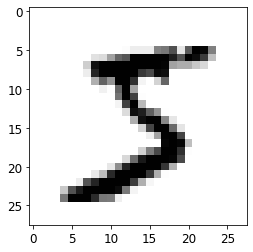

In [9]:
plt.imshow(X_train_full[0], cmap="binary")
plt.show()

Let's visualise more examples in a grid to get a better idea of their characteristics.

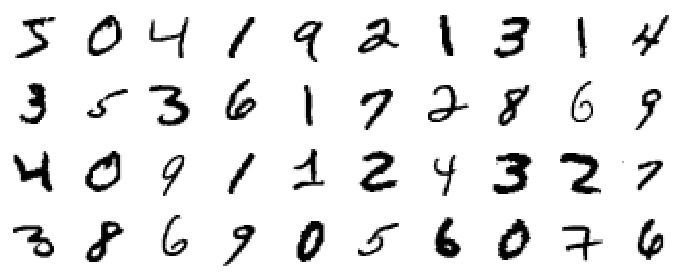

In [10]:
def plot_examples(data, n_rows=4, n_cols=10):
    """Plot a grid of MNIST examples of a specified size."""
    
    # Size figure depending on the size of the grid
    plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
    
    for row in range(n_rows):
        for col in range(n_cols):
            
            # Get next index of image
            index = n_cols * row + col
            
            # Plot the image at appropriate place in grid
            plt.subplot(n_rows, n_cols, index + 1)
            plt.imshow(data[index], cmap="binary")
            plt.axis('off')
            
    plt.show()

plot_examples(X_train_full)

We see that the images are size-normalised and centred. The minimal preprocessing required for this dataset is part of its attraction.

Finally, we need to examine the class labels as this will determine the output encoding of our network.

In [11]:
# Check the format of the label by looking at the first five examples
print(y_train_full[0:5])

# List all unique labels in the training set
print(np.unique(y_train_full))

[5 0 4 1 9]
[0 1 2 3 4 5 6 7 8 9]


As expected, we have ten labels corresponding to the different digits. The labels are provided as indices, as opposed to one hot vectors (where 3 would be represented as ```[0001000000]```).

### Creating a validation set

When training and tuning neural networks, having a third data split called the validation set is very useful. During training we will need to determine the appropriate point to stop training to minimise overfitting, however we should not use the test set to do this, as we may bias our training process to this particular test set, and it would no longer be a fair measure of the generalisation ability of the network. Hence, we can use the validation set for this purpose. Additionally, if we wish to tune hyperparameters it is often infeasible to use k-fold cross validation due to its long runtime, so we are sometimes forced to evaluate a single training run using the validation set instead.

Let's set aside 10% of the original training data for this purpose using sklearn's ```train_test_split```.

In [12]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, train_size=0.9)

### Defining the model

With our data fully prepared, it is now time to design our multilayer perceptron network. Neural network design can be difficult, with infinite possible combinations of hidden layers and numbers of neurons in each. While an MLP with one hidden layer can model any problem with enough neurons, deeper networks with multiple layers often have much higher parameter efficiency, using less weights (and hence less computation) to solve the same problem.

Although there are few firm rules, with practice and exposure to neural networks in different contexts, you will develop an intuition for the appropriate starting design for your network's hidden layers depending on your problem and computational constraints. Tuning these design parameters and stopping training early to avoid overfitting can also help allevaite concern over the initial design.

Today, we aim to solve a relatively simple task, and importantly, we aim to use a network which we can train and evaluate in a feasible time during today's lab. We have defined the following feedforward network below using Keras' Sequential framework ([documentation](https://keras.io/api/models/)), suitable for models where there is a single stack of layers connected sequentially.

In [13]:
# Define our MLP layer by layer
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="tanh"),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(10, activation="softmax")
])

Note that our first layer simply flattens our input for the next layer. Here, we also define the size of the input, which will determine the number of weights between the input layer and first hidden layer. If you do not specify the input shape, Keras will simply wait until you begin to pass data to the model to actually build it.

For our hidden layers, we have utilised the ReLU activation function (different activation functions are discussed below). Each of these dense layers maintains the weight (and bias) matrix for the connections between the neurons and their inputs.

The final layer is determined by the nature of our classification problem. We have ten classes, so we require 10 output neurons, and we utilise the softmax function ($\frac{e^{z_{i}}}{\sum_{j=1}^{K} e^{z_{j}}}$) to convert the raw outputs of this layer into a probability distribution over the classes. 

With so many connections between the neurons in each layer, we can end up with a lot of parameters. Let's take a look at our model using ```model.summary()```.

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


We can also access the model weights directly and inspect them.

In [15]:
weights, biases = model.layers[1].get_weights()

In [16]:
print(weights.shape)
print(biases.shape)

(784, 300)
(300,)


In [17]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [18]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

#### Discussion Question

Note that the biases are initially zero, but the weights are initialised to small values. What would happen if the weights were also initialised to zero?

#### Solution
Geron explains this well in "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow : Concepts, Tools, and Techniques to Build Intelligent Systems" (pp 291):

"If you initialize all weights and biases to zero, then all neurons in a given layer will be perfectly identical, and thus backpropagation will affect them in exactly the same way, so they will remain identical. In other words, despite having hundreds of neurons per layer, your model will act as if it had only one neuron per layer: it won’t be too smart. If instead you randomly initialize the weights, you break the symmetry and allow backpropagation to train a diverse team of neurons."

### Specifying the optimiser and loss function

Before we can use our model, we need to specify some important training parameters and 'compile' the model.

Here, we will use the basic SGD learning algorithm, with a learning rate of 0.1. Our loss function depends on our problem. For a classification task such as ours, we can score the probability distribution output from the softmax layer of our model against the known labels using Cross Entropy loss. Since our labels are in index form rather than encoded as one-hot vectors, as we discussed earlier, we utilise the ```sparse_categorical_crossentropy``` loss. See [here](https://www.tensorflow.org/api_docs/python/tf/keras/losses) for documentation on the available loss functions in Keras. It is important to ensure the loss function you are using is compatible with the format of your labels.

Finally, we need to tell our model that our metric of interest is accuracy, so that this is reported during training and when we evaluate the model.

In [19]:
# Instantiate optimiser and compile the model.
opt = keras.optimizers.SGD(learning_rate=5e-2)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

### Training and evaluating the model

Simple model training in Keras is essentially as easy as in sklearn, which is in stark contrast to many other neural network libraries.

The training process may take several minutes to run depending on your hardware. As training progresses, watch carefully how the training and validation accuracy change and spot if the model begins to overfit the training data.

In [20]:
# Train the classifier.
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.3494 - accuracy: 0.9010 - val_loss: 0.2285 - val_accuracy: 0.9312
Epoch 2/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.1987 - accuracy: 0.9428 - val_loss: 0.1676 - val_accuracy: 0.9510
Epoch 3/20
1688/1688 [==============================] - 7s 4ms/step - loss: 0.1491 - accuracy: 0.9566 - val_loss: 0.1372 - val_accuracy: 0.9608
Epoch 4/20
1688/1688 [==============================] - 6s 3ms/step - loss: 0.1201 - accuracy: 0.9650 - val_loss: 0.1255 - val_accuracy: 0.9653
Epoch 5/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0994 - accuracy: 0.9714 - val_loss: 0.1060 - val_accuracy: 0.9688
Epoch 6/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0846 - accuracy: 0.9755 - val_loss: 0.1022 - val_accuracy: 0.9695
Epoch 7/20
1688/1688 [==============================] - 5s 3ms/step - loss: 0.0729 - accuracy: 0.9791 - val_loss: 0.0913 - val_accuracy:

Calling the ```fit``` method returns a dictionary of the training history, which we can utilise to visualise the change in training and validation accuracy over time.

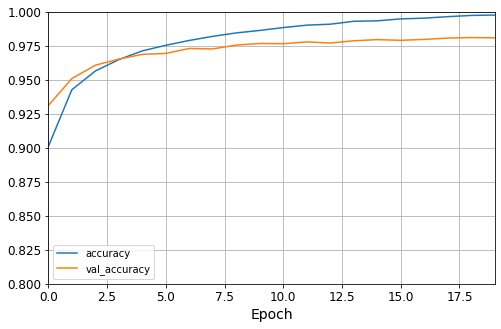

In [21]:
import pandas as pd

# Convert the history dictionary to a Pandas dataframe and extract the accuracies
accuracies = pd.DataFrame(history.history)[['accuracy', 'val_accuracy']]

# Plot the accuracies
accuracies.plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0.8, 1)
plt.xlabel('Epoch')
plt.show()

Evidently, choosing the appropriate place to stop our training is important. While this can be done manually, there are also different methods (such as [Keras callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping)) to automate 'early stopping' from the validation accuracy trends.

To ultimately check the model's generalisation ability, we should evaluate on the test set, which had no influence in the training process.

In [22]:
# Evaluate the classifier on the test data.
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")

313/313 [==============================] - 0s 1ms/step - loss: 0.0638 - accuracy: 0.9795
Accuracy on test data: 0.9795


We can also look directly at our model's predictions. The ```predict``` method will return the final outputs from our model - recall this was a probability distribution over the different classes.

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


To get the index of the class with the maximum probability (our model's class prediction), we can use the following snippet:

In [24]:
y_pred = np.argmax(y_proba, axis=-1)
print(y_pred)

[7 2 1]


Let's verify the predictions by inspecting the corresponding images.

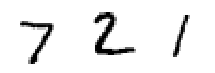

In [25]:
plot_examples(X_test, n_rows=1, n_cols=3)

## 4. Parameter Search for Neural Networks

Hyperparameter tuning is especially difficult for neural networks due to two factors. 

Firstly, the flexibility of neural networks means there are many possible hyperparameters to tweak. In a basic MLP implementation, parameters we can possibly tune include:
- number of hidden layers
- number of neurons in each layer
- activation functions
- learning rate
- optimiser
- batch size 

The second difficulty is that the runtime of neural networks is generally much higher than traditional ML algorithms unless we run our algorithms on powerful GPUs (which can better parallelise the computations).

The result is that we often have to tradeoff between an exhaustive parameter search and a long runtime.

Let's define a function which allows us to quickly build a Keras model with our desired parameters. We can use this to try out different parameter combinations!

In [26]:
def build_mlp(
    n_hidden_layers=2, n_hidden_neurons=50,
    activation_function="relu", input_shape=[28,28], learning_rate=0.01
):
    """Build a Keras MLP for 10 class classification with desired parameters."""
    
    model = keras.models.Sequential()
    
    # Add the input layer
    model.add(keras.layers.Flatten(input_shape=input_shape))
    
    # Add the hidden layers with desired size and activation function
    for layer in range(n_hidden_layers):
        model.add(keras.layers.Dense(n_hidden_neurons, activation=activation_function))
        
    # Add the output layer for 10 class classification
    model.add(keras.layers.Dense(10, activation="softmax"))
    
    return model

### Using sklearn grid searches with Keras models

We could conduct a parameter search by writing our own loop over parameter values and simply using the validation set to approximate the performance of the different combinations.

However, it is also possible to use sklearn's parameter search utilities with Keras models. Previously, this functionality was included in Keras as ```keras.wrappers.scikit_learn```, however the functionality has now been taken over by SciKeras

Using SciKeras, we can use a wrapper which allows our Keras classifier to act like a typical sklearn classifier. The wrapper will handle the compilation of our model, and we need to pass the parameters we wish to tune as arguments to its constructor. From there, we can set up a grid search just like we have in the previous weeks!

In [27]:
from scikeras.wrappers import KerasClassifier

# Create a KerasClassifier object which works with sklearn grid searches
# We need to pass default values of arguments in build_mlp if we wish to tune them
keras_classifier = KerasClassifier(build_fn=build_mlp,
                                   n_hidden_layers=2,
                                   n_hidden_neurons=50,
                                   activation_function="relu",
                                   loss="sparse_categorical_crossentropy",
                                   optimizer="sgd",
                                   learning_rate=0.01,
                                   metrics=["accuracy"]
                                  )

For now, let's consider models with two hidden layers and tune over several other parameters.

The following cell will take a long time to run (possibly several hours depending on your hardware), and it is **not recommended to run it during the lab**.

In [ ]:
"""This cell has a long runtime. Not recommended during lab."""
from sklearn.model_selection import GridSearchCV

param_grid = {
    "n_hidden_neurons": [100, 200],
    "learning_rate": [0.1, 0.01, 0.001],
    "activation_function": ["relu", "sigmoid", "tanh"]
}

grid_search_cv = GridSearchCV(keras_classifier, param_grid, cv=3, verbose=2)
grid_search_cv.fit(X_train, y_train, epochs=20)

In [ ]:
print(grid_search_cv.best_params_)
best_model = grid_search_cv.best_estimator_.model_

For even larger models than the MLPs we have considered here, exhaustive grid search and cross validation quickly become infeasible. Other than using more powerful hardware, one approach is to run a broad initial search using the validation set, and then narrow the search space once appropriate starting parameters are identified. There also exist many algorithsm to more efficiently search the hyperparameter space such as Bayesian Search. Ultimately, however, there is no escpaing neural network's need for computation power and their long runtimes. This is one reason why neural networks are not always the most appropriate solution to your problem.

## 5. Task - Using an MLP for Regression

Today we have demonstrated how to create an image classifier MLP. Beyond multi-class classification problems, MLPs can also be used to solve other types of problems, such as binary classification and regression. To do this, we may need to change the output encoding.

For binary classification we can use 2 output neurons (1 for each class) as before, or 1 neuron only with sigmoid (logistic) output layer activation (values close to 0 represent class 0, values close to 1 represent class 1).

In regression problems, if we predict a single value (e.g. the price of a house or the exchange rate of the Australian dollar), we will need a single output neuron. If we want to predict multiple values, e.g. the electricity consumption for tomorrow for every hour (24 values), then there should be one output neuron per predicted value. No output activation is necessarily required, but ReLU may be used if the output must be positive, and sigmoid/tanh can be used for bounded outputs. The other change for regression problems is the loss function (cross entropy is not appropriate for regression). Mean squared error (MSE) ([Keras documentation](https://keras.io/api/losses/)) is often used.

Below we have loaded and preprocessed the Boston Housing dataset, which contains 13 numerical attibutes of houses of Boston suburbs in the late 1970s. The target variable is the house price in thousands of dollars. For more details on the actual attributes, you can view this [link](http://lib.stat.cmu.edu/datasets/boston).

In [28]:
# Load the Boston Housing data
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.boston_housing.load_data()

In [29]:
print(f"Shape of X_train_full: {X_train_full.shape}")
print(f"Shape of y_train_full: {y_train_full.shape}")
print(f"Shape of X_test: {X_test.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of X_train_full: (404, 13)
Shape of y_train_full: (404,)
Shape of X_test: (102, 13)
Shape of y_test: (102,)


In [30]:
np.random.seed(42)
tf.random.set_seed(42)
keras.backend.clear_session()

In [31]:
from sklearn.preprocessing import StandardScaler

# Create a validation set
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

# Standardise the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

### Task
Define, train and evaluate a regression MLP on this dataset. To achieve this, you will need to:
- Remember to adjust the input shape and output layer appropriately for this dataset
- Compile the model with an appropriate loss function
- Interpret the evaluation, since for this regression problem accuracy is not a valid metric

### Solution:

This is one possible simple solution using the same hidden layer structure as above.

In [32]:
# Define our Keras model with appropriate input size and output
model = keras.Sequential([
    keras.layers.Dense(300, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1)
])

# Compile model with MSE loss
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [33]:
# Train the model
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
10/10 [==============================] - 0s 11ms/step - loss: 547.7675 - val_loss: 330.2329
Epoch 2/20
10/10 [==============================] - 0s 4ms/step - loss: 211.8402 - val_loss: 63.3655
Epoch 3/20
10/10 [==============================] - 0s 4ms/step - loss: 49.4029 - val_loss: 32.2598
Epoch 4/20
10/10 [==============================] - 0s 6ms/step - loss: 31.1562 - val_loss: 25.3474
Epoch 5/20
10/10 [==============================] - 0s 5ms/step - loss: 25.2875 - val_loss: 20.0847
Epoch 6/20
10/10 [==============================] - 0s 4ms/step - loss: 22.2691 - val_loss: 17.7285
Epoch 7/20
10/10 [==============================] - 0s 4ms/step - loss: 20.0409 - val_loss: 15.9388
Epoch 8/20
10/10 [==============================] - 0s 5ms/step - loss: 18.2024 - val_loss: 14.6660
Epoch 9/20
10/10 [==============================] - 0s 3ms/step - loss: 17.1464 - val_loss: 13.4113
Epoch 10/20
10/10 [==============================] - 0s 3ms/step - loss: 16.0479 - val_loss: 12.

In [34]:
# Evaluate the model using MSE as a metric
mse_test = model.evaluate(X_test, y_test)

4/4 [==============================] - 0s 5ms/step - loss: 23.4793


In [35]:
# Examine several model predictions
y_pred = model.predict(X_test[:3])

for i in range(3):
    print(f"Model prediction: {y_pred[i][0]:.2f}; True value: {y_test[i]}")

Model prediction: 9.95; True value: 7.2
Model prediction: 17.18; True value: 18.8
Model prediction: 21.42; True value: 19.0


## 6. Summary

Today, we have only scratched the surface of Keras' functionality. It is a rich library with lots of possible customisation, and a 'Functional API' ([documentation](https://keras.io/guides/functional_api/)) to create more complex models. Nevertheless, hopefully this provides a springboard for your further study and utilisation of deep learning libraries.

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="tanh"),
    keras.layers.Dense(100, activation="tanh"),
    keras.layers.Dense(10, activation="softmax")
])

opt = keras.optimizers.SGD(learning_rate=5e-2)
model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

loss, accuracy = model.evaluate(X_test, y_test)
print(f"Accuracy on test data: {accuracy:.4f}")

## Acknowledgements

This tutorial is based on:

Aurelien Geron (2022). Hands-on Machine Learning with Scikit-Learn, Keras and TensorFlow, O'Reilly.